In [65]:
col_names = [
#     'dv', 
    'fv',
    'dv-fv'
]

years = [
#     '2009',
#     '2010',
#     '2011',
    '2012',
    '2013',
    '2014',
    '2015',
    '2016',
    '2017',
    '2018',
]

In [66]:
import configparser
import warnings
from pymongo import MongoClient

warnings.filterwarnings("ignore", category=DeprecationWarning)

config = configparser.ConfigParser()
config.read('config.ini')
host = config['DEFAULT']['IP']
port = config['DEFAULT']['MongoDB-Port']

client = MongoClient(host, int(port))
db = client['Media-cloud']

# Story Counts Venn Diagram

In [3]:
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
# Get counts of each collection 

# count_fv = db['fv'].find({}).count()
# count_dv = db['dv'].find({}).count()
# count_fv_dv = db['dv-fv'].find({}).count()

count_fv = 2560
count_dv = 8088
count_fv_dv = 2248

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Number of FV and DV Stories 2009-2018')
venn2(subsets = (count_fv, count_dv, count_fv_dv), set_labels = ('Family Violence', 'Domestic Violence'))
plt.show()

# Top Words for Each Year

In [5]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# Stop words
stop = set(stopwords.words('english'))
stop.update([
    'say',
    'would',
    'year',
    'one',
    'go',
    'get',
    'take',
    'also',
    'need',
    'want',
    'make',
    'family',
    'domestic',
    'mr',
    'people',
    'give',
    'could',
    'day',
    'week'
])

# Lemmatizer
lmtz = WordNetLemmatizer()

In [6]:
# Lemmatize words to their base form

def lemmatize(token):
    lemma = lmtz.lemmatize(token, 'v')
    if lemma == token:
        lemma = lmtz.lemmatize(token, 'n')
    return lemma

In [8]:
freqs = {}                           # Word frequency
for col_name in col_names:
    col = db[col_name]
    counter = 0                      # Count processed stories and display

    for story in col.find({}, no_cursor_timeout=True):
        if story['publish_date'] != None:
            date_time = story['publish_date']

            try:
                year = date_time.split(' ')[0].split('/')[-1]
                
                if story['text'] != None:
                    text = story['text']

                    for token in word_tokenize(text):
                        if token.isalpha():
                            lemma = lemmatize(token.lower())               # Lemmatize word and update its frequency
                            if lemma not in stop:
                                year_freqs = freqs.get(year, {})
                                year_freqs[lemma] = year_freqs.get(lemma, 0) + 1
                                freqs[year] = year_freqs

                counter += 1
                if counter % 1000 == 0:
                    print(counter,'precessed')
            except:
                pass

1000 precessed
2000 precessed
1000 precessed
2000 precessed


In [15]:
# yearly comparison

for year in years:
    print(year)
    year_freq = freqs[year]
    
    count = 0 

    for word in sorted(year_freq, key=year_freq.get, reverse=True):
        if word not in []:
            print(word)
            count += 1
            if count == 30:
                break
    
    print()

2012
drug
police
pappa
law
violence
phillips
former
report
time
use
judge
death
australian
think
new
find
body
lynette
coate
health
jail
state
dr
kozminsky
minister
carr
victoria
support
offender
ben

2013
violence
woman
police
court
child
report
victim
men
order
work
community
issue
state
service
time
victoria
young
intervention
per
crime
home
number
government
abrahimzadeh
cent
see
problem
change
come
leave

2014
violence
police
woman
child
government
time
community
service
court
victoria
luke
order
work
victim
report
state
crime
new
batty
death
know
last
think
abuse
tell
issue
call
use
help
many

2015
violence
woman
government
police
child
service
victim
community
court
time
report
support
work
australia
fund
australian
help
call
order
state
legal
change
new
tell
abuse
know
find
come
issue
men

2016
violence
woman
government
child
service
police
time
court
report
community
work
australian
support
act
victim
state
australia
fund
new
per
house
cent
call
include
help
find
leave
law
cha

In [ ]:
# # Bar chart

# import numpy as np

# x = []          # X axis - top words
# y = []          # Y axis - word counts
# count = 0       # Numer of top words to show

# for word in sorted(freqs, key=freqs.get, reverse=True):
#     x.append(word)
#     y.append(freqs[word])
#     count += 1
#     if count == 15:
#         break

# plt.figure(figsize=(16,8))
# index = np.arange(len(x))
# plt.bar(index, y)
# plt.xlabel('Word', fontsize=20)
# plt.ylabel('Count', fontsize=20)
# plt.xticks(index, x, fontsize=15, rotation=30)
# plt.title('Top Words from FV and DV Stories 2009-2018')
# plt.show()

# Top Themes

In [16]:
# Compute frequency for each theme from the database

freq = {}
for col_name in col_names:
    col = db[col_name]
    counter = 0
    
    for story in col.find({}):
        s = story['themes']
        if s != None:
            for split in s.split(','):
                theme = split.strip()
                freq[theme] = freq.get(theme, 0) + 1
                
        counter += 1
        if counter % 500 == 0:
            print(counter, 'processed')

500 processed
1000 processed
1500 processed
2000 processed
2500 processed
500 processed
1000 processed
1500 processed
2000 processed


In [ ]:
x = []                       # Themes
y = []                       # Story counts
count = 0

for theme in sorted(freq, key=freq.get, reverse=True):
    if theme == 'domestic violence':
        continue
    x.append(theme)
    theme_freq = freq[theme]
    y.append(theme_freq)
    n += 1
    if n == 15:                   # Limit the number of top themes
        break
    
plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Theme', fontsize=20)
plt.ylabel('Story Counts', fontsize=20)
plt.xticks(index, x, fontsize=15, rotation=30)
plt.title('Top Themes from FV and DV Stories 2009-2018')
plt.show()

In [17]:


labels = []                       
sizes = []                        
n = 0                             

for theme in sorted(freq, key=freq.get, reverse=True):
    if theme == 'domestic violence':
        continue
    labels.append(theme)
    theme_freq = freq[theme]
    sizes.append(theme_freq)
    n += 1
    if n == 10:                   
        break

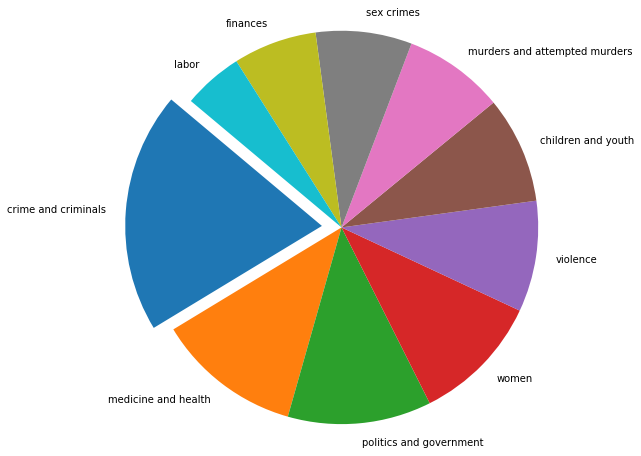

In [18]:
plt.figure(figsize=(8,8))
explode = (0.1,0,0,0,0,0,0,0,0,0)                       # Emphasize the first theme
plt.pie(sizes, labels=labels, startangle=140, explode=explode)  # Display in percentage
 
plt.axis('equal')
plt.show()

# Top Entities (Person, Orgnisation, Location)

In [19]:
# Named entity recognition - Spacy library
# Need to run "python -m spacy download en" & "python -m spacy download en_core_web_sm"

import spacy

nlp = spacy.load('en_core_web_sm')          # English language

In [20]:
person_freqs = {}                    # Named persons - how many percent of stories mentioned them
org_freqs = {}                       # Organisations
loc_freqs = {}                       # Locations

for col_name in col_names:
    col = db[col_name]
    counter = 0                      # Count processed stories and track
    
    for story in col.find({}, no_cursor_timeout=True):
        if story['text'] != None:
            text = story['text']
            
            counted_ents = set()                                      # Count entities only once for each story
            for ent in nlp(text).ents:                                # Spacy named entities
                name = ent.text
                
                if name not in counted_ents:
                    counted_ents.add(name)
                    
                    if ent.label_ == 'PERSON':
                        person_freqs[name] = person_freqs.get(name, 0) + 1
                    if ent.label_ == 'ORG':
                        org_freqs[name] = org_freqs.get(name, 0) + 1
                    if ent.label_ == 'GPE':                                          # Countries/states/...
                        loc_freqs[name] = loc_freqs.get(name, 0) + 1
                    
        counter += 1
        if counter % 100 == 0:
            print(counter, 'processed')

100 processed
200 processed
300 processed
400 processed
500 processed
600 processed
700 processed
800 processed
900 processed
1000 processed
1100 processed
1200 processed
1300 processed
1400 processed
1500 processed
1600 processed
1700 processed
1800 processed
1900 processed
2000 processed
2100 processed
2200 processed
2300 processed
2400 processed
2500 processed
100 processed
200 processed
300 processed
400 processed
500 processed
600 processed
700 processed
800 processed
900 processed
1000 processed
1100 processed
1200 processed
1300 processed
1400 processed
1500 processed
1600 processed
1700 processed
1800 processed
1900 processed
2000 processed
2100 processed
2200 processed


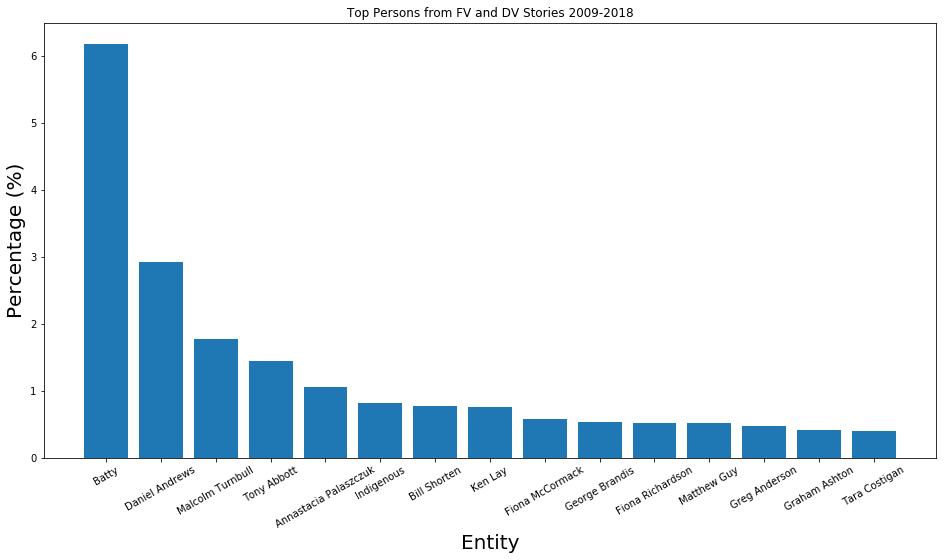

In [24]:
import numpy as np
# We combine all the stories under Luke Batty, Rosie Batty and Batty into Batty bucket

# Top persons

freqs = person_freqs

# Adjust for same entities
freqs['Malcolm Turnbull'] += freqs['Turnbull']
freqs['Turnbull'] = 0
freqs['Tony Abbott'] += freqs['Abbott']
freqs['Abbott'] = 0
freqs['Daniel Andrews'] += freqs['Andrews']
freqs['Andrews'] = 0
freqs['Annastacia Palaszczuk'] += freqs['Palaszczuk']
freqs['Palaszczuk'] = 0
freqs['Batty'] += freqs['Rosie Batty'] + freqs['Luke'] + freqs['Ms Batty'] + freqs['Luke Batty']
freqs['Luke Batty'] = 0
freqs['Ms Batty'] = 0
freqs['Luke'] = 0
freqs['Rosie Batty'] = 0
freqs['Donald Trump'] += freqs['Trump']
freqs['Trump'] = 0
 
x = []          # X axis - entities
y = []          # Y axis - percentage of stories with the entity
count = 0       # Numer of top entities to show

for ent in sorted(freqs, key=freqs.get, reverse=True):
    
    # Error values
    if ent.strip() not in ['', 'Victoria', 'Victoria Police', 'Mum','Bill','Darwin']:                          
        x.append(ent)
        total = count_dv+count_fv+count_fv_dv                                  # Total num of stories
        y.append(freqs[ent]/total*100)                                         # Percentage
        count += 1
        if count == 15:                                                        # Limit the num of entities to show
            break

plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Entity', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
plt.xticks(index, x, fontsize=10, rotation=30)
plt.title('Top Persons from FV and DV Stories 2009-2018')
plt.show()

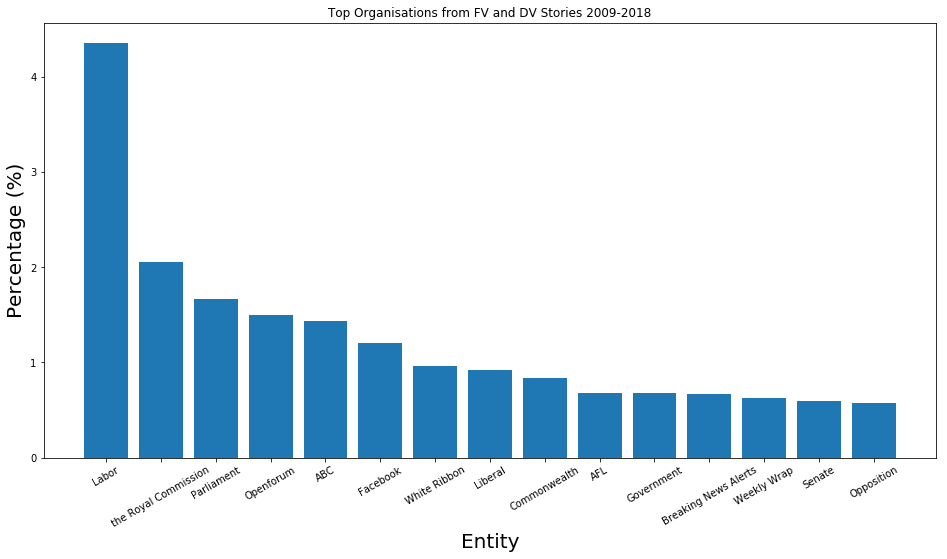

In [35]:
# Top orgs

freqs = org_freqs

# Adjust for same entities
freqs['Labor'] += freqs['ALP'] + freqs['the Labor Party']
freqs['ALP'] = 0
freqs['the Labor Party'] = 0

freqs['Liberal'] += freqs['the Liberal Party']
freqs['the Liberal Party'] = 0



x = []          # X axis - entities
y = []          # Y axis - percentage of stories with the entity
count = 0       # Numer of top entities to show

for ent in sorted(freqs, key=freqs.get, reverse=True):
    
    # Error values
    if ent.strip() not in ['',
                           'NSW',
                           'ACT',
                           'Fairfax Media',
                           'Brisbane',
                           'Family Violence',
                           'Western Australia',
                           'CCTV',
                           'The Canberra Times',
                           'Media',
                           'CBD',
                           'WA',
                           'State',
                           'FAQ'
                          ]:     
        y.append(freqs[ent]/total*100)
        if 'Discussion Terms' in ent:
            ent = 'Openforum'
        x.append(ent)
        total = count_dv+count_fv+count_fv_dv                                  # Total num of stories
        count += 1
        if count == 15:
            break

plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Entity', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
plt.xticks(index, x, fontsize=10, rotation=30)
plt.title('Top Organisations from FV and DV Stories 2009-2018')
plt.show()

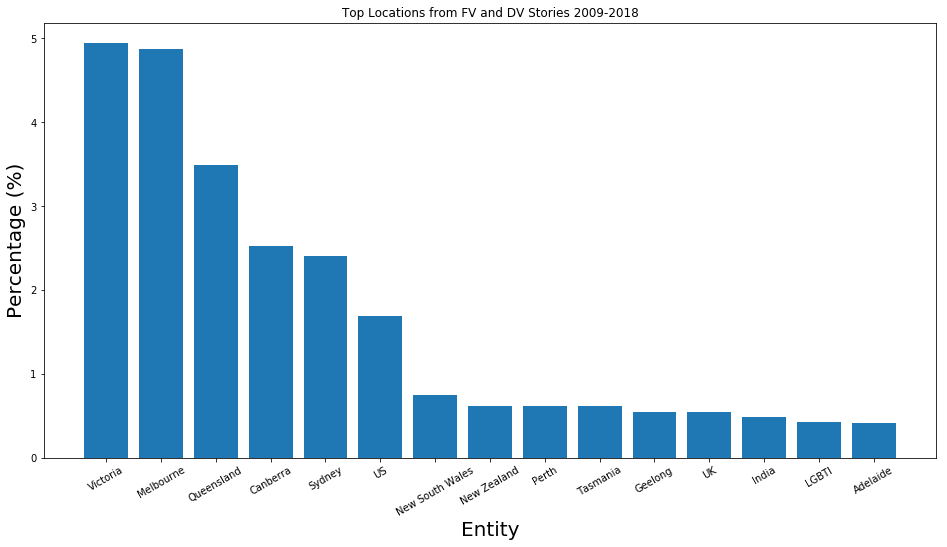

In [36]:
# Top locations

freqs = loc_freqs

freqs['US'] += freqs['the United States']
freqs['the United States'] = 0

x = []          # X axis - entities
y = []          # Y axis - percentage of stories with the entity
count = 0       # Numer of top entities to show

for ent in sorted(freqs, key=freqs.get, reverse=True):
    
    # Error values
    if ent.strip() not in ['',
                           'Fairfax',
                           'Twitter',
                           'Australia'
                          ]:                          
        x.append(ent)
        total = count_dv+count_fv+count_fv_dv                                  # Total num of stories
        y.append(freqs[ent]/total*100)                                         # Percentage
        count += 1
        if count == 15:
            break

plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Entity', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
plt.xticks(index, x, fontsize=10, rotation=30)
plt.title('Top Locations from FV and DV Stories 2009-2018')
plt.show()

# Day of Week Pattern

In [56]:
import datetime

freqs = [0]*7
for col_name in col_names:
    col = db[col_name]
    for story in col.find({}, no_cursor_timeout=True):
        try:
            publish_date = story['publish_date'].split(' ')[0]
            date = datetime.datetime.strptime(publish_date, '%d/%m/%Y')
            day = date.weekday()
            
            freqs[day] += 1
            
        except:
            pass

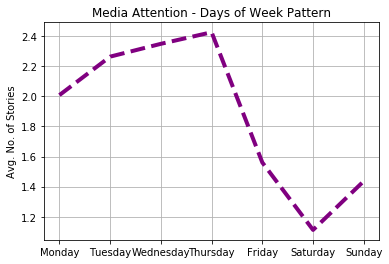

In [61]:
from pylab import *

avg_freqs = [(freq/52/len(years)) for freq in freqs]

day = ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday')
plot(day, avg_freqs, color='purple', linewidth=4, linestyle='--')
 
ylabel('Avg. No. of Stories')
title('Media Attention - Days of Week Pattern')
grid(True)
show()

# Help Seeking Info Analysis

In [82]:
help_lines = {
    'Lifeline': '131114', 
    'Mensline': '1300789978',
    'Kids Helpline': '1800551800',
    '1800 RESPECT': '1800737732',
    'DV Connect Mensline': '1800600636',
    'DV Connect Womensline': '1800811811',
    'Triple Zero': '000',
    'National Disability Abuse and Neglect Hotline': '1800880052',
    '24-hour emergency line 2': '64581828',
    '24-hour emergency line': '1800199888',
    'Domestic Violence Line': '1800656463'
}

In [70]:
total = db['fv'].find({}).count() + db['dv-fv'].find({}).count()
total

4789

In [ ]:
num_help_info = 0
help_line_freqs = {}
counter = 0

for col_name in col_names:
    col = db[col_name]
    
    for story in col.find({}, no_cursor_timeout=True):
        text = story['text'].replace(' ', '').replace('-', '').lower().strip()
        
        for name, number in help_lines.items():
            name_lower = name.replace(' ', '').replace('-', '').lower()
            if name_lower in text or number in text:
                num_help_info += 1
                help_line_freqs[name] = help_line_freqs.get(name, 0) + 1
                
        counter += 1
        if counter % 100 == 0:
            print(counter)

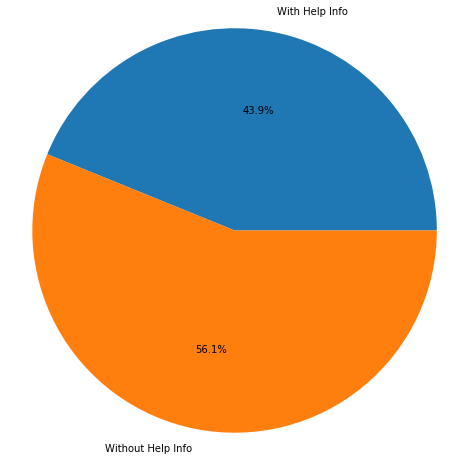

In [85]:
sizes = [num_help_info, total-num_help_info]
labels = ['With Help Info', 'Without Help Info']

plt.figure(figsize=(8,8))
explode = (0,0)
plt.pie(sizes, autopct='%1.1f%%', labels=labels, explode=explode) 
 
plt.axis('equal')
plt.show()

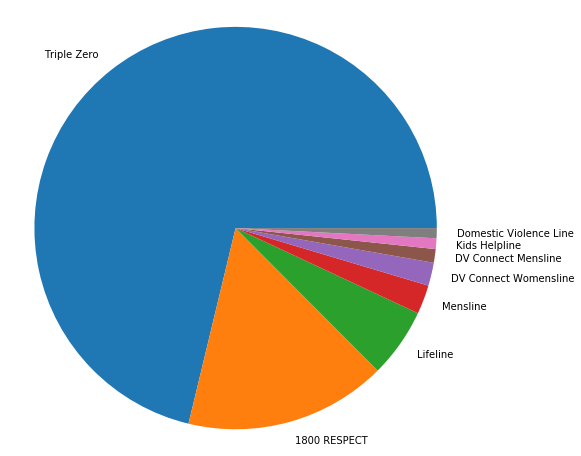

In [88]:
labels = []                       
sizes = []                        
n = 0                             

for line in sorted(help_line_freqs, key=help_line_freqs.get, reverse=True):
    labels.append(line)
    sizes.append(help_line_freqs[line])
    n += 1
    if n == 100:                   
        break
        
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels)  # Display in percentage
 
plt.axis('equal')
plt.show()

In [87]:
help_line_freqs

{'Triple Zero': 1496,
 '1800 RESPECT': 341,
 'Lifeline': 117,
 'Mensline': 49,
 'Kids Helpline': 18,
 'DV Connect Mensline': 23,
 'DV Connect Womensline': 39,
 'Domestic Violence Line': 17}

In [102]:
# numbers = set()
# numbers.update([
#     '131114', 
#     '1300789978',
#     '1800551800',
#     '1800737732',
#     '1800600636',
#     '1800811811',
#     '000',
#     '1800880052',
#     '64581828',
#     '1800199888',
#     '1800656463'
# ])

# for col_name in col_names:
#     col = db[col_name]
    
#     for story in col.find({'$text': {'$search': '", call"'}}, no_cursor_timeout=True):
#         text = story['text'].strip()+'#'
        
#         i = 0
#         while i < len(text)-5:
#             if not text[i].isdigit():
#                 i += 1
#             else:
#                 j = i+1
#                 while j < len(text) and (text[j].isdigit() or text[j] == ' '):
#                     j += 1
#                 num = text[i: j].replace(' ','').strip()
#                 if len(num) > 5:
#                     if num not in numbers:
#                         numbers.add(num)
#                 i = j+1